Trabajo Práctico Final- Procesamiento de Señales Biomédicas

***Detección de Hipertrofia de Ventrículo Izquierdo mediante ML***



*   Bautista Dipaola
*   Lucas Son



#Consigna

1. Preprocesar los datos mediante filtros adecuados para el ECG
2. Detectar los complejos QRS de los registros
3. Extracción de características en complejos QRS y ondas T (sugerencia: pueden ser las amplitudes y
las duraciones de cada onda)
4. Separación de las características mediante algoritmo de clustering Kmeans (lo vimos en clase) con
K = 2 (un grupo hipertrófico y otro no)
5. Estadística de resultados sobre cada grupo. Para esto hagan graficos de cajas con las medias y
duraciones de cada onda en cada grupo, y test de hipotesis (t-test por ej.) para saber si son
significativamente diferentes, asi se podrá apreciar si el clustering logró separar las características
efectivamente o no.
6. Clasificación de los grupos mediante un algoritmo supervisado. Armado de la matriz de características y labels. Permutacion de las mismas, separación en 70-30 para entrenamiento-
testeo. Obtención de la matriz de confusión.
 



#Características de la señal
45 pacientes. Cada paciente es una estructura "Pt" en matlab con varios
campos. Los campos de interés son:
* ***Pt.ECG:*** las 12 derivaciones de ECG de cada paciente
* ***Pt.fm:*** la frec de muestreo
* ***Pt.labels:*** la etiqueta de si es hipertrofico o no (0: sano, 1: hipertrofico)
* ***Pt.fiduciales:*** los puntos fiduciales del ECG (les puede servir para analizar complejo QRS por un lado y onda T por el otro). Descartar los registros que tengan menos de 10 puntos fiduciales por cada onda.

Se realizó un preacondicionamiento de los datos usando MATLAB para comodidad al momento de extraer los datos y automaticamente eliminamos a los pacientes que tengan menos de 10 registros

In [ ]:
pip install sklearn

Librerías

In [ ]:
#Librerías generales
import numpy as np 
from scipy import signal as sp
from scipy import stats
import scipy.io as sio
import matplotlib.pyplot as plt



#Parte de ML
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd


Montaje del Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Extracción de Características

Primero, trabajamos con la D2 de un único paciente para controlar que la extracción sea correcta.

Importamos la señal

In [ ]:
data1= sio.loadmat('/content/drive/Shareddrives/TP Final PSB/Señales a usar/ECG.mat')

print(sorted(data1.keys()))

fs=1000
QRS_duracion = []
T_duracion = []
QRS_pendientes = []
T_pendientes = []

# Levantamos D2 de un paciente

Num_paciente=0 ##Tomamos al primer Paciente (Aristegui)
j=Num_paciente*7 #Esto es por como fue acondicionado el archivo ECG.mat

ECG_D2 = data1['ECG'][0][0][j][:,7]
QRSon = data1['ECG'][0][0][j+1]
QRSend = data1['ECG'][0][0][j+2]
T = data1['ECG'][0][0][j+3]
R = data1['ECG'][0][0][j+4]
Ton = data1['ECG'][0][0][j+5]
Tend = data1['ECG'][0][0][j+6]

['ECG', '__globals__', '__header__', '__version__']


Filtramos los registros que sean NaN, para obtener datos solo numéricos

In [ ]:
#________
#Filtramos los nans
QRSon_Nan  = ~np.isnan(QRSon)
QRSend_Nan =~np.isnan(QRSend)
T_Nan = ~np.isnan(T)
R_Nan = ~np.isnan(R)
Ton_Nan = ~np.isnan(Ton)
Tend_Nan = ~np.isnan(Tend)

# Nos quedamos sólamente el que más cantidades de Nan posee
QRS_Nan = QRSon_Nan * QRSend_Nan * R_Nan
ondaT_Nan = T_Nan * Ton_Nan * Tend_Nan

# Limpiamos los Nan de cada registro
QRSon = [k[0] for k,l in zip(QRSon, QRS_Nan) if l]
QRSend = [k[0] for k,l in zip(QRSend, QRS_Nan) if l]
T = [k[0] for k,l in zip(T, ondaT_Nan) if l]
R = [k[0] for k,l in zip(R, QRS_Nan) if l]
Ton = [k[0] for k,l in zip(Ton, ondaT_Nan) if l]
Tend = [k[0] for k,l in zip(Tend, ondaT_Nan) if l]



Graficamos para ver ECG

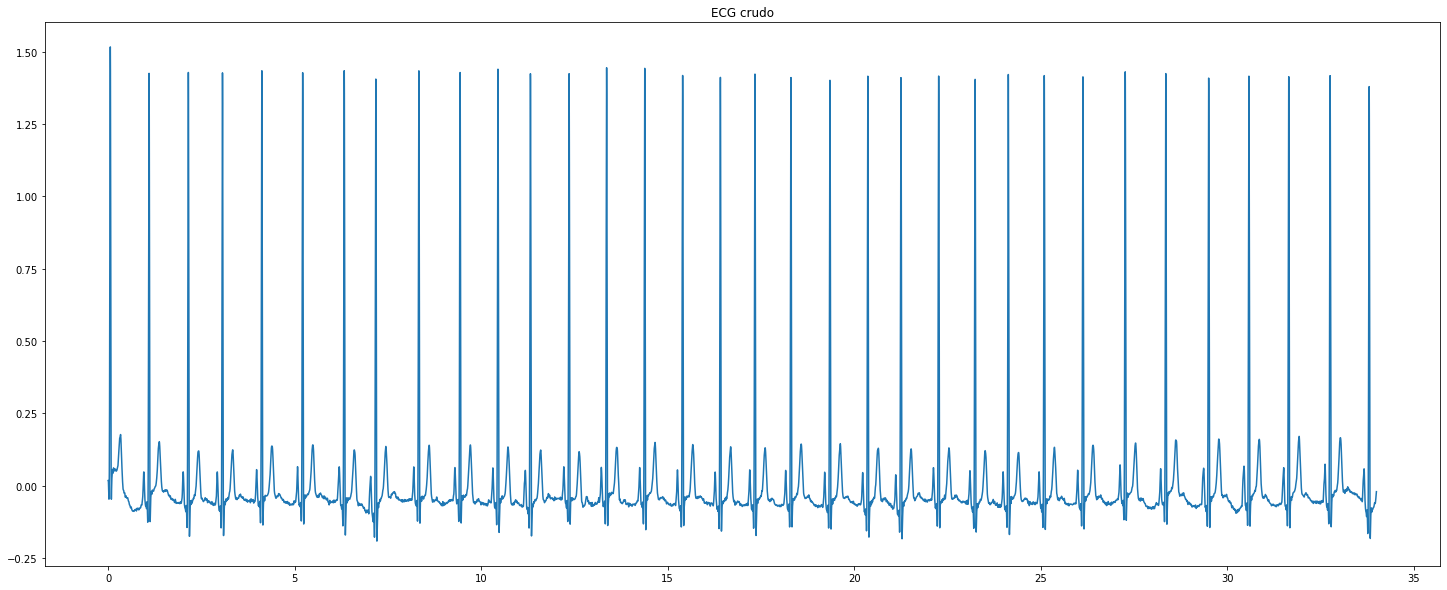

In [ ]:
R = np.array(R)
R = R.astype(int)
t = np.linspace(0,len(ECG_D2)/fs,len(ECG_D2))
plt.figure(figsize=(25,10))
plt.title("ECG crudo")
plt.plot(t,ECG_D2)
plt.show()


Filtramos la señal de ECG. Para ello, usamos dos tipos de filtros:


*   Un Filtro Notch para eliminar el ruido de línea
*   Un Filtro Pasabanda para acotar el ancho de banda de la D2 del ECG entre 0.5 y 100 Hz, además de eliminar el movimiento de la línea de base.



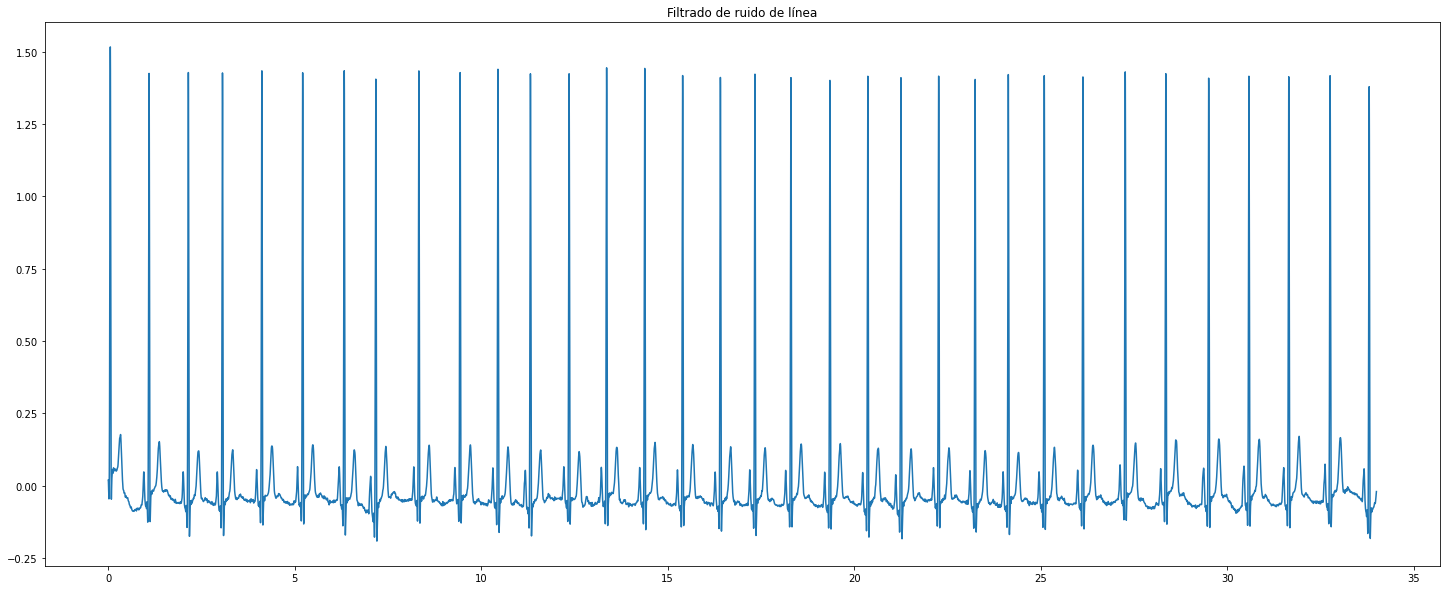

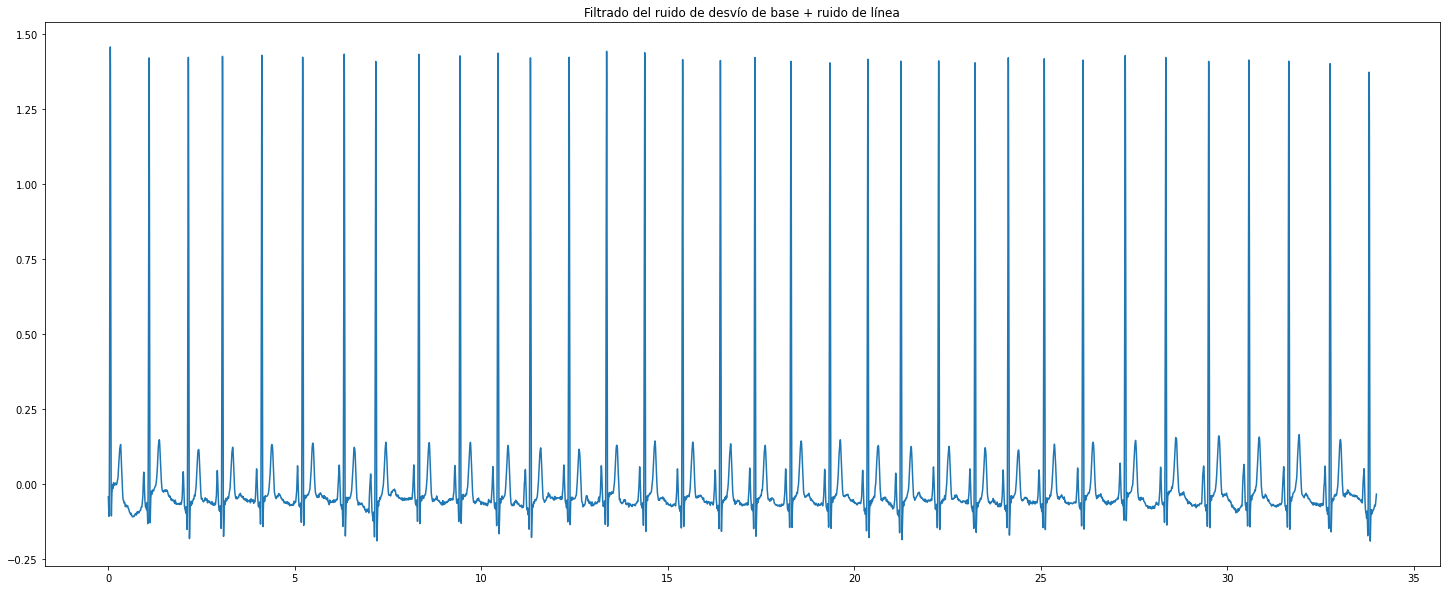

In [ ]:

# FILTRO NOTCH

b_notch, a_notch = sp.iirnotch(50,20,fs)
ECG_filtrado = sp.filtfilt(b_notch, a_notch, ECG_D2)
plt.figure(figsize=(25,10))
plt.title("Filtrado de ruido de línea")
plt.plot(t,ECG_filtrado)
plt.show()

#FILTRO PASABANDA
N =4 #orden
nyq = 0.5 * fs
low = 0.5 / nyq
high = 100/ nyq

wn = [low,high]

bbp, abp = sp.butter(N, wn, btype='band')

ECG_filtrado = sp.filtfilt(bbp, abp, ECG_filtrado)
plt.figure(figsize=(25,10))
plt.title("Filtrado del ruido de desvío de base + ruido de línea")
plt.plot(t,ECG_filtrado)
plt.show()

Graficamos los espectros de los filtros

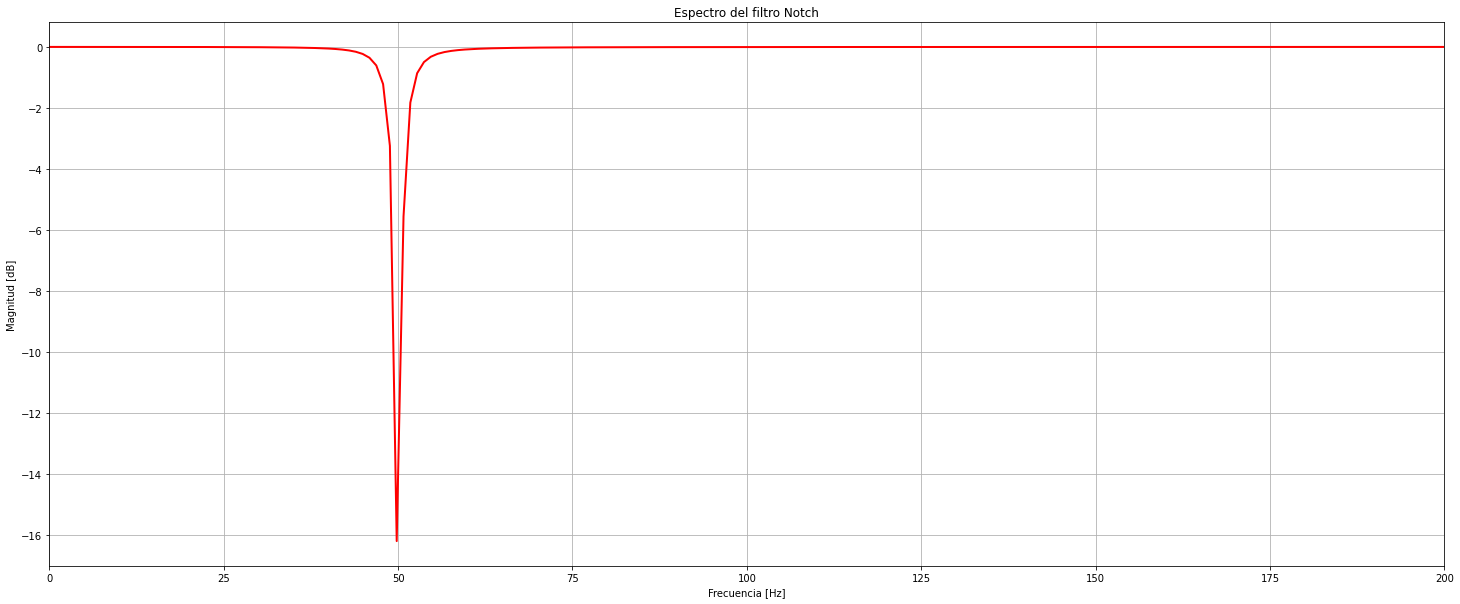

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


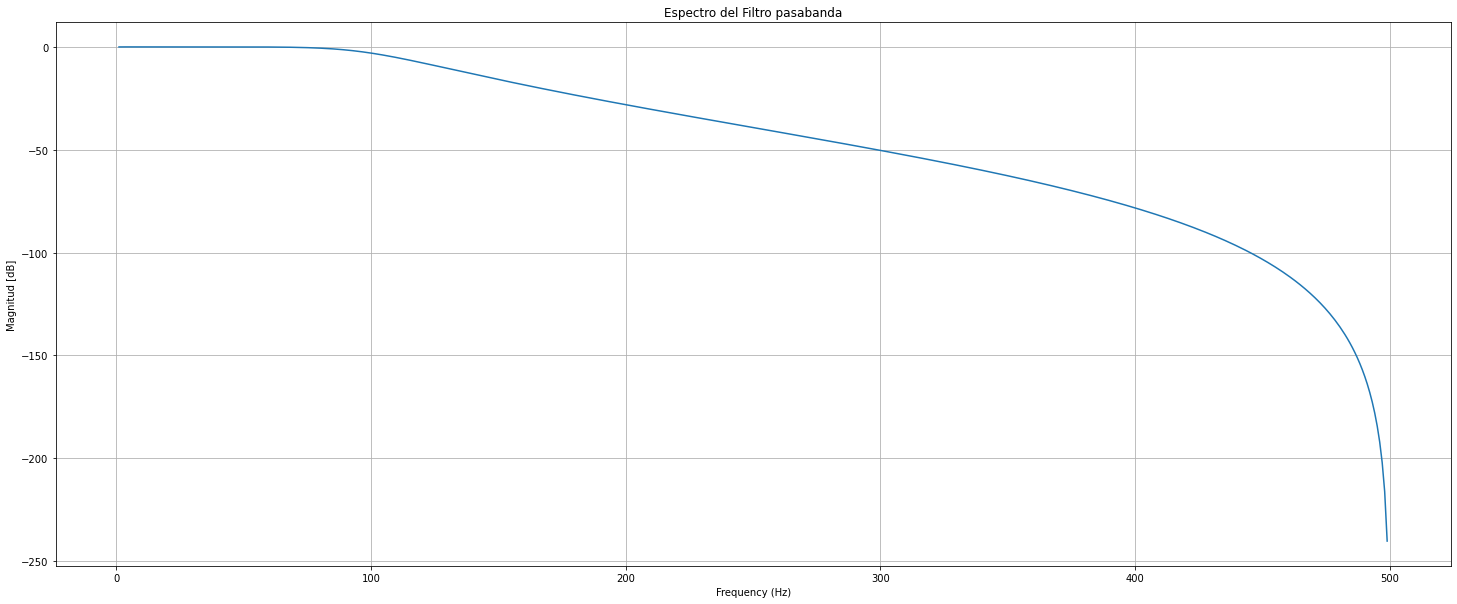

In [ ]:
#ESPECTROS DE LOS FILTROS
#Notch
freq, h = sp.freqz(b_notch, a_notch, fs=fs)
plt.figure(figsize=(25,10))
plt.plot(freq, 20 * np.log10(abs(h)), 'r', linewidth='2')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Magnitud [dB]')
plt.title('Espectro del filtro Notch')
plt.xlim(0,200)
plt.grid()
plt.show()

#Pasabanda:
plt.figure(figsize=(25,10))
w, h = sp.freqz(bbp, abp)
plt.plot((fs * 0.5 / np.pi) * w,20 * np.log10(abs(h)))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitud [dB]')
plt.title("Espectro del Filtro pasabanda")
plt.grid(True)
plt.show()

Buscamos los espectrogramas del ECG crudo y el ECG filtrado para verificar que el filtrado se haya efectuado correctamente

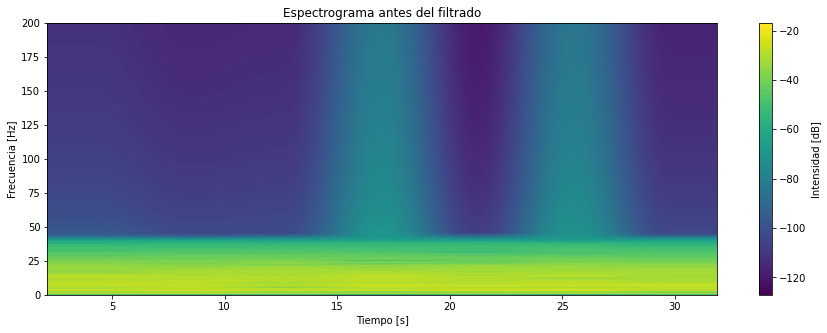

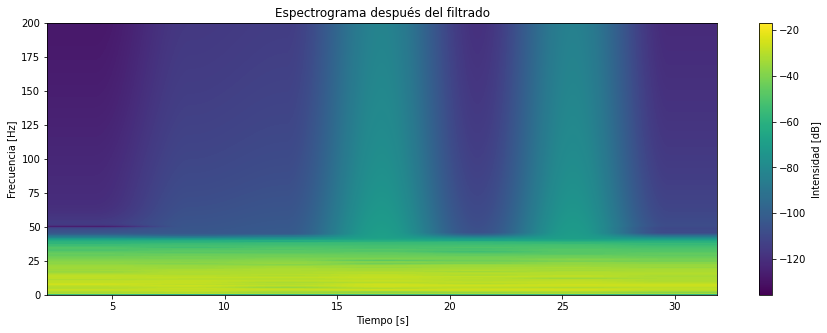

In [ ]:
#ESPECTROGRAMAS


# Antes de los filtros
N_specgram = int(len(ECG_D2)*0.25)
Hamming = sp.windows.hamming(N_specgram)

fig,ax = plt.subplots(figsize=(15,5))
ax.set_title('Espectrograma antes del filtrado')
espectrograma = ax.specgram(ECG_D2,NFFT=N_specgram,Fs = fs,window = Hamming,noverlap = N_specgram/2)
fig.colorbar(espectrograma[3]).set_label('Intensidad [dB]')
ax.set(xlabel = 'Tiempo [s]', ylabel = 'Frecuencia [Hz]')
ax.set_ylim((0,200))
plt.show()


# Después de los filtros
Hamming = sp.windows.hamming(N_specgram)
fig,ax = plt.subplots(figsize=(15,5))
ax.set_title('Espectrograma después del filtrado')
espectrograma = ax.specgram(ECG_filtrado,NFFT=N_specgram,Fs = fs,window = Hamming,noverlap = N_specgram/2)
fig.colorbar(espectrograma[3]).set_label('Intensidad [dB]')
ax.set(xlabel = 'Tiempo [s]', ylabel = 'Frecuencia [Hz]')
ax.set_ylim((0,200))
plt.show()

Extraemos las siguientes características de 1 solo paciente:


*   Duracion QRS
*   Amplitud QRS
*   Pendiente de subida QR
*   Pendiente de bajada RS
*   Duracion onda T
*   Amplitud onda T
*   Pendiente de subida de la onda T (desde el comienzo hasta la deteccion)
*   Pendiente de bajada de la onda T (desdela deteccion hasta el final)







In [ ]:
#Duraciones de los QRS

lenQRS= np.array(QRSend)-np.array(QRSon)

lenT=np.array(Tend)-np.array(Ton)

QRS_duracion_avg = np.mean(lenQRS)
T_duracion_avg = np.mean(lenT)


#__________________________________________________________________________________________________----

#PENDIENTES Y AMPLITUDES
#Pendientes y amplitudes de la onda QRS
pteQR=[]
pteRS=[]
amplitudesQRS=[]
print(len(R))
for h in range (0,len(R)):
    Q_inicio = int(QRSon[h])
    Q_final = int(QRSend[h])
    if (Q_inicio < Q_final):
        R_picomax = np.argmax(ECG_filtrado[int(QRSon[h]):int(QRSend[h])])+int(QRSon[h])
        S_picomin = np.argmin(ECG_filtrado[int(QRSon[h]):int(QRSend[h])])+int(QRSon[h])
        pteQR = np.append(pteQR,(ECG_filtrado[R_picomax]-ECG_filtrado[Q_inicio])/((R_picomax-Q_inicio)/fs))
        pteRS = np.append(pteRS,(ECG_filtrado[S_picomin]-ECG_filtrado[R_picomax])/((S_picomin-R_picomax)/fs))
        amplitudesQRS = np.append(amplitudesQRS,ECG_filtrado[R_picomax]-ECG_filtrado[S_picomin])

    
pte_avgQR=np.mean(pteQR) #Valor promedio de la pendiente QR de un paciente
pte_avgRS=np.mean(pteRS) #Valor promedio de la pendiente RS de un paciente
amplitud_avg=np.mean(amplitudesQRS)


#Pendientes y amplitudes de la onda T
pteT1=[]
pteT2=[]
amplitudesT=[]
print(len(R))
for h in range (0,len(T)):
    T_inicio = int(Ton[h])
    T_final = int(Tend[h])
    if (T_inicio < T_final):
        T_pico = int(T[h])
        if (ECG_filtrado[T_inicio] < ECG_filtrado[T_pico]):
            T_pico = np.argmax(ECG_filtrado[T_inicio:T_final])+T_inicio
        else:
            T_pico = np.argmin(ECG_filtrado[T_inicio:T_final])+T_inicio

        pteT1 = np.append(pteT1,(ECG_filtrado[T_pico]-ECG_filtrado[T_inicio])/((T_pico-T_inicio)/fs))
        pteT2 = np.append(pteT2,(ECG_filtrado[T_final]-ECG_filtrado[T_pico])/((T_final-T_pico)/fs))
        amplitudesT = np.append(amplitudesT,ECG_filtrado[T_pico])

    
pte_avgT1=np.mean(pteT1) #Valor promedio de la pendiente QR de un paciente
pte_avgT2=np.mean(pteT2) #Valor promedio de la pendiente RS de un paciente
amplitud_Tavg=np.mean(amplitudesT)

31
31


Detección De Segmentos QRS mediante el Algortimo de Pan y Tompkins

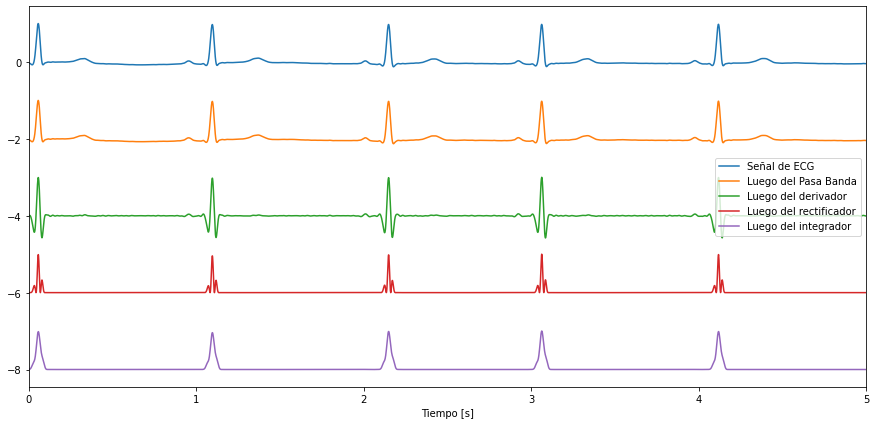

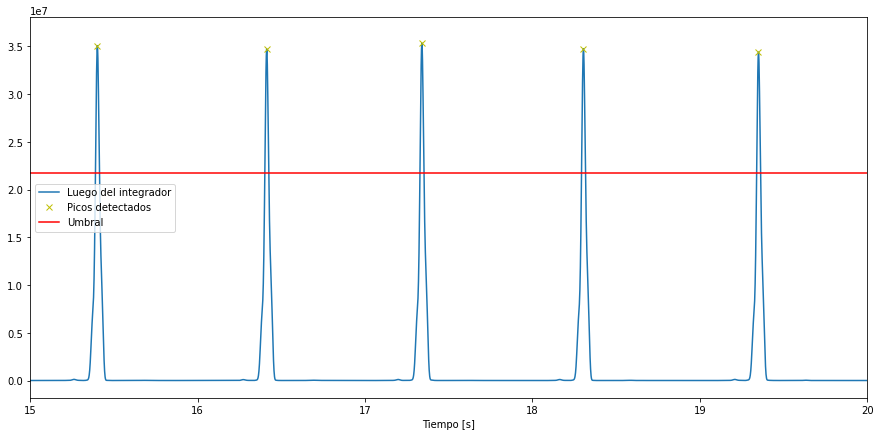

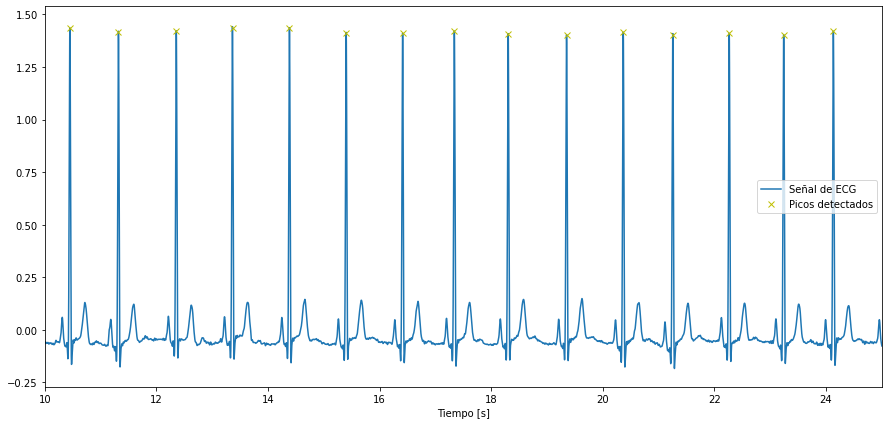

In [ ]:
#______________________________________________________
#DETECTOR QRS

N = len(ECG_filtrado)
t = np.linspace(0,N/fs,N)


def detectorQRS(ECG,fs,etapas=False):
  #Como se utiliza filtfilt para evitar retrasos, el orden de los filtros es en realidad el doble 

  #Pasa banda
  orden_BP = 20
  banda = [10,15]
  b_BP = sp.firwin(orden_BP+1,banda,fs = fs)
  ECG_BP = sp.filtfilt(b_BP,1,ECG)

  #Filtro derivativo
  L = 8 #skip factor
  b_D = np.append(np.append([1],np.zeros(2*L - 1)),[-1])*(fs/(2*L))
  ECG_D = sp.filtfilt(b_D,1,ECG_BP)

  #Cuadrado
  ECG_sq = ECG_D**2

  #Integrador
  orden_I = 20
  b_I = np.ones(orden_I)*(1/orden_I)
  ECG_I = sp.filtfilt(b_I,1,ECG_sq)

  picos, properties = sp.find_peaks(ECG_I,0.4 * max(ECG_I))

  if etapas == True:
    return picos, [ECG_BP,ECG_D,ECG_sq,ECG_I]
  elif etapas == False:
    return picos

picos,[ECG_BP,ECG_D,ECG_sq,ECG_I] = detectorQRS(ECG_filtrado,fs,etapas=True)

intervalo_temporal = [0,5]

plt.figure(figsize=(15,7))
plt.plot(t,ECG_filtrado/np.amax(ECG_filtrado))
plt.plot(t,ECG_BP/np.amax(ECG_BP) - 2)
plt.plot(t,ECG_D/np.amax(ECG_D) - 4)
plt.plot(t,ECG_sq/np.amax(ECG_sq) - 6)
plt.plot(t,ECG_I/np.amax(ECG_I) - 8)
plt.xlim(intervalo_temporal)
plt.xlabel('Tiempo [s]')
plt.legend(['Señal de ECG','Luego del Pasa Banda','Luego del derivador','Luego del rectificador','Luego del integrador'])
plt.show()

intervalo_temporal = [15,20]

t_picos = t[picos]

plt.figure(figsize=(15,7))
plt.plot(t,ECG_I)
plt.plot(t_picos,ECG_I[picos],'yx')
plt.plot(np.ones(len(ECG_I))*0.4*np.max(ECG_I),'r')
plt.xlim(intervalo_temporal)
plt.xlabel('Tiempo [s]')
plt.legend(['Luego del integrador','Picos detectados','Umbral'])
plt.show()


intervalo_temporal = [10,25]

plt.figure(figsize=(15,7))
plt.plot(t,ECG_filtrado)
plt.plot(t_picos,ECG_filtrado[picos],'xy')
plt.xlim(intervalo_temporal)
plt.xlabel('Tiempo [s]')
plt.legend(['Señal de ECG','Picos detectados'])
plt.show()

Graficamos como queda la detección

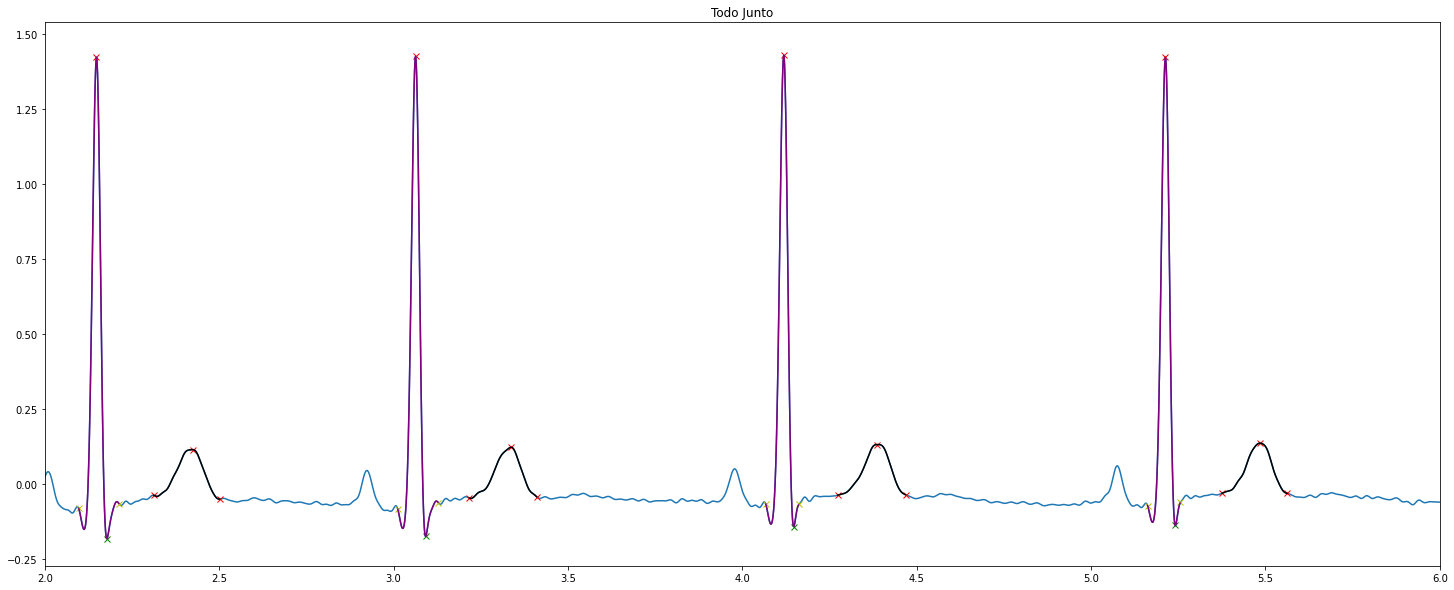

In [ ]:
plt.figure(figsize=(25,10))
plt.title('Todo Junto')
plt.plot(t,ECG_filtrado)
l = min([len(T),len(R)])
for k in range(0,l):
    T_inicio = int(Ton[k])
    T_final = int(Tend[k])
    Q_inicio = int(QRSon[k])
    Q_final = int(QRSend[k])
    if (T_inicio < T_final) and (Q_inicio < Q_final):
        T_pico = int(T[k])
        if (ECG_filtrado[T_inicio] < ECG_filtrado[T_pico]):
            T_pico = np.argmax(ECG_filtrado[T_inicio:T_final])+T_inicio
        else:
            T_pico = np.argmin(ECG_filtrado[T_inicio:T_final])+T_inicio
        R_picomax = np.argmax(ECG_filtrado[Q_inicio:Q_final])+Q_inicio
        S_picomin = np.argmin(ECG_filtrado[R_picomax:Q_final])+R_picomax
        ECG_R = ECG_filtrado[R_picomax]
        ECG_S = ECG_filtrado[S_picomin]
        plt.plot(T_inicio/fs,ECG_filtrado[T_inicio],'rx')
        plt.plot(T_final/fs,ECG_filtrado[T_final],'rx')
        plt.plot(T_pico/fs,ECG_filtrado[T_pico],'rx')
        plt.plot(Q_inicio/fs,ECG_filtrado[Q_inicio],'yx')
        plt.plot(Q_final/fs,ECG_filtrado[Q_final],'yx')
        plt.plot(R_picomax/fs,ECG_R,'rx')
        plt.plot(S_picomin/fs,ECG_S,'gx')
        plt.plot(t[int(Ton[k]):int(Tend[k])],ECG_filtrado[int(Ton[k]):int(Tend[k])],"k")
        plt.plot(t[int(QRSon[k]):int(QRSend[k])],ECG_filtrado[int(QRSon[k]):int(QRSend[k])],"purple")

plt.xlim(2,6)
plt.show()

#Extracción de características para cada uno de los pacientes



Se realizó un procedimiento análogo pero incorporando cada característica a una matriz que posteriormente será utilizada para las etapas de ML

In [ ]:
data1= sio.loadmat('/content/drive/Shareddrives/TP Final PSB/Señales a usar/ECG.mat')



print(sorted(data1.keys()))

matriz=[]
datos=[]
apellidos = []

fs=1000


data2=sio.loadmat('/content/drive/Shareddrives/TP Final PSB/Señales a usar/HVI.mat')


['ECG', '__globals__', '__header__', '__version__']


In [ ]:
for i in range(0,40):
    j = i * 7
    
    # Levantamos los distintos registros dentro de la estructura ECG    
    QRSon = data1['ECG'][0][0][j+1]
    QRSend = data1['ECG'][0][0][j+2]
    T = data1['ECG'][0][0][j+3]
    R = data1['ECG'][0][0][j+4]
    Ton = data1['ECG'][0][0][j+5]
    Tend = data1['ECG'][0][0][j+6]
    Apellido=str(data2["HVI"][0][0][0][:,0][i][0])
    diag_hvi=data2["HVI"][0][0][1][:,0][i]

    # Levantamos D2
    ECG_D2 = data1['ECG'][0][0][j][:,7]
    


    # Identificamos los Nan dentro de cada registro
    QRSon_Nan  = ~np.isnan(QRSon)
    QRSend_Nan =~np.isnan(QRSend)
    T_Nan = ~np.isnan(T)
    R_Nan = ~np.isnan(R)
    Ton_Nan = ~np.isnan(Ton)
    Tend_Nan = ~np.isnan(Tend)

    # Nos quedamos sólamente el que más cantidades de Nan posee
    QRS_Nan = QRSon_Nan * QRSend_Nan * R_Nan
    ondaT_Nan = T_Nan * Ton_Nan * Tend_Nan

    # Limpiamos los Nan de cada registro
    QRSon = [k for k,l in zip(QRSon, QRS_Nan) if l]
    QRSend = [k for k,l in zip(QRSend, QRS_Nan) if l]
    T = [k for k,l in zip(T, ondaT_Nan) if l]
    R = [k for k,l in zip(R, QRS_Nan) if l]
    Ton = [k for k,l in zip(Ton, ondaT_Nan) if l]
    Tend = [k for k,l in zip(Tend, ondaT_Nan) if l]

    #---------------------------------------------------
    # Filtrado de D2 ECG
    #---------------------------------------------------
    
    
    #Filtro notch para ruido de linea
    
    N =4 #orden
    wn = [49,51]

    b_notch, a_notch = sp.iirnotch(50,20,fs)
    ECG_filtrado_notch = sp.filtfilt(b_notch, a_notch, ECG_D2)
    
    #Filtro pasa banda para filtrar el desvío de la línea de base

    N =4 #orden
    nyq = 0.5 * fs
    low = 0.5 / nyq
    high = 100/ nyq

    wn = [low,high]

    bbp, abp = sp.butter(N, wn, btype='band')

    ECG_filtrado = sp.filtfilt(bbp, abp, ECG_filtrado_notch)
#______________________________________________________________________________________________________________________________________________________________________________________________
#______________________________________________________________________________________________________________________________________________________________________________________________
    
    #Buscamos las distintas características de interés
    #-------------------------------------------------
    # Duración de onda QRS y onda T
    #---------------------------------------------------
    lenQRS= np.array(QRSend)-np.array(QRSon)

    lenT=np.array(Tend)-np.array(Ton)

    QRS_duracion_avg =np.mean(lenQRS)
    T_duracion_avg = np.mean(lenT)


    #---------------------------------------------------
    # Amplitudes y Pendientes de onda QRS
    #---------------------------------------------------
    
    pteQR=[]
    pteRS=[]
    amplitudesQRS=[]
    for h in range (0,len(R)):
        Q_inicio = int(QRSon[h])
        Q_final = int(QRSend[h])
        if (Q_inicio < Q_final):
            R_picomax = np.argmax(ECG_filtrado[Q_inicio:Q_final])+Q_inicio
            S_picomin = np.argmin(ECG_filtrado[int(R[h]):Q_final])+int(R[h])
            pteQR = np.append(pteQR,(ECG_filtrado[R_picomax]-ECG_filtrado[Q_inicio])/((R_picomax-Q_inicio)/fs))
            pteRS = np.append(pteRS,(ECG_filtrado[S_picomin]-ECG_filtrado[R_picomax])/((S_picomin-R_picomax)/fs))
            amplitudesQRS = np.append(amplitudesQRS,ECG_filtrado[R_picomax]-ECG_filtrado[S_picomin])
        

    QRS_amplitud_avg= np.mean(amplitudesQRS)
    pendienteQR_avg = np.mean(pteQR)#Valor promedio de la pendiente QR de un paciente
    pendienteRS_avg= np.mean(pteRS)#Valor promedio de la pendiente RS de un paciente



    #---------------------------------------------------
    # Amplitudes y Pendientes de onda T
    #---------------------------------------------------
    pteT1=[]
    pteT2=[]
    amplitudesT=[]
    for h in range (0,len(T)):
        T_inicio = int(Ton[h])
        T_final = int(Tend[h])
        if (T_inicio < T_final):
            T_pico = int(T[h])
            if (ECG_filtrado[T_inicio] < ECG_filtrado[T_pico]):
                T_pico = np.argmax(ECG_filtrado[T_inicio:T_final])+T_inicio
            else:
                T_pico = np.argmin(ECG_filtrado[T_inicio:T_final])+T_inicio
                
            pteT1 = np.append(pteT1,(ECG_filtrado[T_pico]-ECG_filtrado[T_inicio])/((T_pico-T_inicio)/fs))
            pteT2 = np.append(pteT2,(ECG_filtrado[T_final]-ECG_filtrado[T_pico])/((T_final-T_pico)/fs))
            amplitudesT = np.append(amplitudesT,ECG_filtrado[T_pico])
    
    pendienteT1_avg=np.mean(pteT1) #Valor promedio de la pendiente QR de un paciente
    pendienteT2_avg=np.mean(pteT2) #Valor promedio de la pendiente RS de un paciente
    T_amplitud_avg=np.mean(amplitudesT)
    
    fila1 = [np.around(QRS_duracion_avg,3), np.around(QRS_amplitud_avg,3), np.around(pendienteQR_avg,3),np.around(pendienteRS_avg,3),np.around(T_duracion_avg,3),np.around(T_amplitud_avg,3),np.around(pendienteT1_avg,3),np.around(pendienteT2_avg,3)]
    fila1 = np.array(fila1)
    datos = np.append(datos, fila1)
    
    fila2 = [Apellido , str(np.around(QRS_duracion_avg,3)), str(np.around(QRS_amplitud_avg,3)), str(np.around(pendienteQR_avg,3)),str(np.around(pendienteRS_avg,3)),str(np.around(T_duracion_avg,3)),str(np.around(T_amplitud_avg,3)),str(np.around(pendienteT1_avg,3)),str(np.around(pendienteT2_avg,3)),str(np.around(diag_hvi,3))]
    fila2=np.array(fila2)
    matriz=np.append(matriz,fila2)

datos=np.transpose(datos)
datos=np.reshape(datos,(40,8))

matriz=np.transpose(matriz)
matriz=np.reshape(matriz,(40,10))
    

targets = data2["HVI"][0][0][1][:,0]



Armamos la matriz de datos

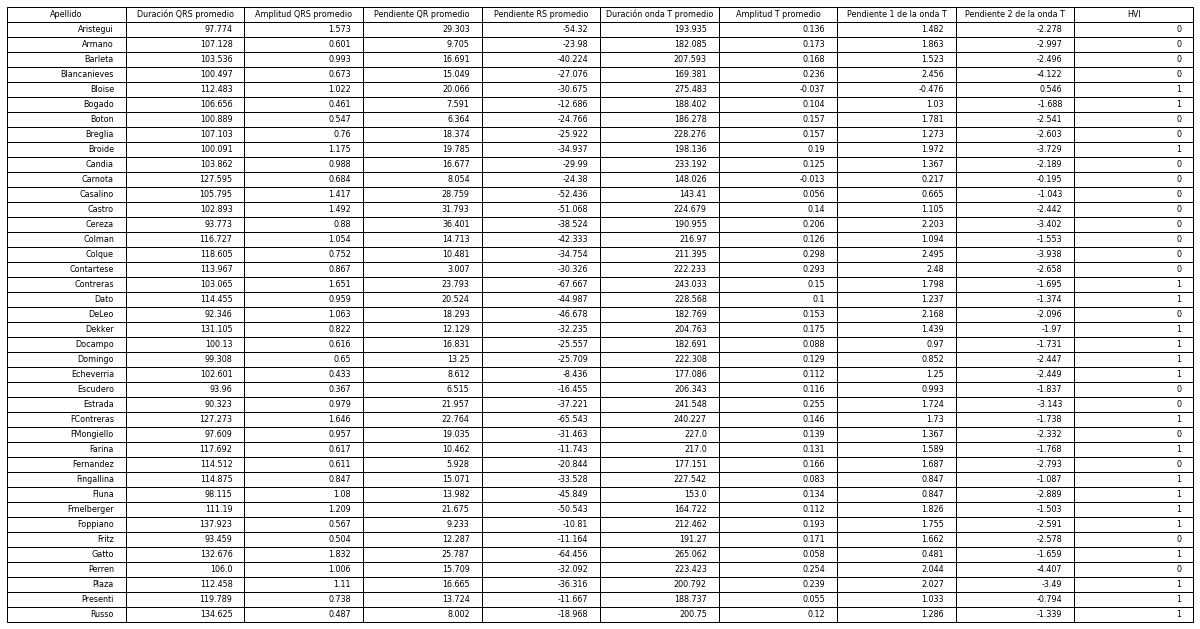

In [ ]:
# TABLA DE DATOS

column_labels=["Apellido" , "Duración QRS promedio", "Amplitud QRS promedio","Pendiente QR promedio","Pendiente RS promedio","Duración onda T promedio","Amplitud T promedio","Pendiente 1 de la onda T","Pendiente 2 de la onda T","HVI"]
fig, ax= plt.subplots(figsize=(17,10))
ax.axis('tight')
ax.axis('off')
table=ax.table(cellText=matriz,colLabels=column_labels,loc='center')
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1.25, 1.25)
plt.show()



#Aprendizaje No Supervisado

Se utilizó la matriz de datos para armar un modelo de clustering en base al algoritmo "KMeans". Se realizó una prueba con todos los datos como input para evaluar la precisión del diagnóstico teniendo en cuenta las marcas en el archivo original.

In [ ]:
X=scale(datos)
kmeans = KMeans(n_clusters=2).fit(X)
print("0 --> Paciente sano\n1--> HVI ")



Grupo_sano_real=0
Grupo_HVI_real=0
Grupo_sano_predicho=0
Grupo_HVI_predicho=0
Aciertos=0
Errados=0
for elemento in range(len(kmeans.labels_)):
    if kmeans.labels_[elemento]==targets[elemento]:
        Aciertos+=1
    else:
        Errados+=1
    if kmeans.labels_[elemento]==1:
        Grupo_HVI_predicho+=1
    else:
        Grupo_sano_predicho+=1
    if targets[elemento]==1:
        Grupo_sano_real+=1
    else:
        Grupo_HVI_real+=1

tasa_aciertos= (Aciertos/(Aciertos + Errados))*100

print("----------------- PRIMER KMEANS ------------------\n")
print("las marcas originales son: ", targets)
print("Las marcas establecidas por el KMeans son: ",kmeans.labels_)

print("Hay", Grupo_HVI_real, "pacientes con HVI y ",Grupo_sano_real, " pacientes sanos segun las marcas del médico")
print("Hay", Grupo_HVI_predicho, "pacientes con HVI y ",Grupo_sano_predicho, " pacientes sanos segun el algoritmo de clustering")
print("Hay ", Aciertos ," Aciertos y ", Errados , "datos clasificados de forma errónea")
print('Entonces, el porcentaje de aciertos es del:',tasa_aciertos,"%")

0 --> Paciente sano
1--> HVI 
----------------- PRIMER KMEANS ------------------

las marcas originales son:  [0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 1 1 0 1 1 1 1 0 0 1 0 1 0 1 1 1 1 0 1 0
 1 1 1]
Las marcas establecidas por el KMeans son:  [1 0 0 0 1 0 0 0 0 0 1 1 1 0 1 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0
 0 1 0]
Hay 21 pacientes con HVI y  19  pacientes sanos segun las marcas del médico
Hay 13 pacientes con HVI y  27  pacientes sanos segun el algoritmo de clustering
Hay  24  Aciertos y  16 datos clasificados de forma errónea
Entonces, el porcentaje de aciertos es del: 60.0 %


Se realizaron Boxplots y tests t para comparar estadísticamente cada característica entre un paciente sano y uno con HVI, según la clasificación hecha por el KMeans

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


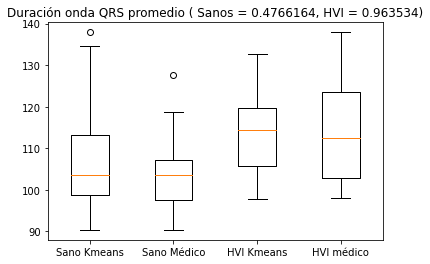

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


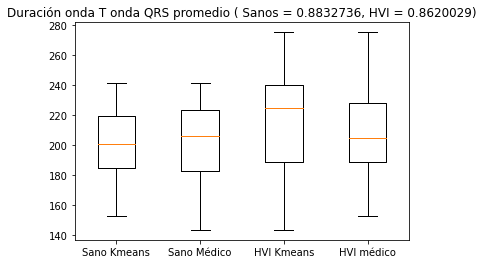

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


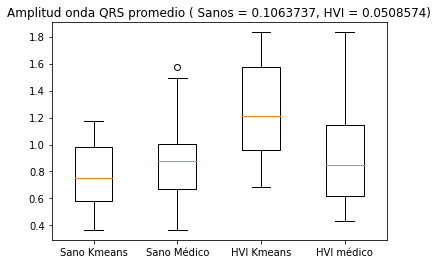

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


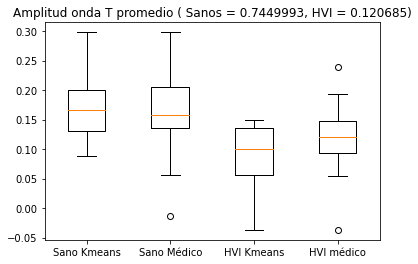

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


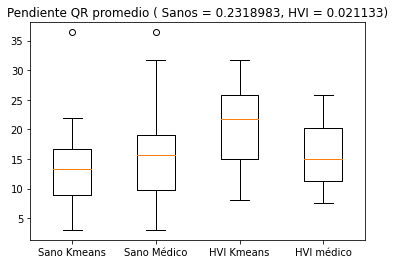

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


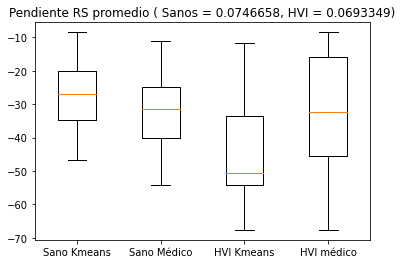

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


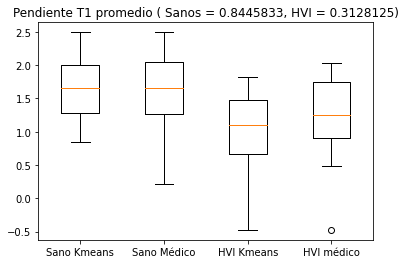

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


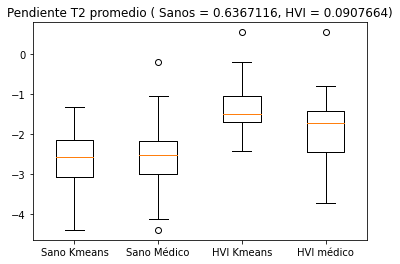

In [ ]:
#_________________________________________________________________________________________
# BOXPLOTS
#Diagnostico del médico
mDuracion_QRS_avg_Sano = []
mDuracion_QRS_avg_HVI = []
mDuracion_T_avg_Sano = []
mDuracion_T_avg_HVI = []
mAmplitud_QRS_avg_Sano = []
mAmplitud_QRS_avg_HVI = []
mAmplitud_T_avg_Sano=[]
mAmplitud_T_avg_HVI=[]
mPendienteQR_avg_Sano = []
mPendienteQR_avg_HVI = []
mPendienteRS_avg_Sano = []
mPendienteRS_avg_HVI = []
mPendienteT1_avg_Sano = []
mPendienteT1_avg_HVI=[]
mPendienteT2_avg_Sano = []
mPendienteT2_avg_HVI = []

for dato in range(len(targets)):
    if targets[dato] == 0:
        mDuracion_QRS_avg_Sano = np.append(mDuracion_QRS_avg_Sano,datos[dato,0])
        mAmplitud_QRS_avg_Sano = np.append(mAmplitud_QRS_avg_Sano,datos[dato,1])
        mPendienteQR_avg_Sano = np.append(mPendienteQR_avg_Sano,datos[dato,2])
        mPendienteRS_avg_Sano = np.append(mPendienteRS_avg_Sano,datos[dato,3])
        mDuracion_T_avg_Sano = np.append(mDuracion_T_avg_Sano,datos[dato,4])
        mAmplitud_T_avg_Sano= np.append(mAmplitud_T_avg_Sano,datos[dato,5])          
        mPendienteT1_avg_Sano = np.append(mPendienteT1_avg_Sano,datos[dato,6])
        mPendienteT2_avg_Sano = np.append(mPendienteT2_avg_Sano,datos[dato,7])

    else: 
        mDuracion_QRS_avg_HVI = np.append(mDuracion_QRS_avg_HVI,datos[dato,0])
        mAmplitud_QRS_avg_HVI = np.append(mAmplitud_QRS_avg_HVI,datos[dato,1])
        mPendienteQR_avg_HVI = np.append(mPendienteQR_avg_HVI,datos[dato,2])
        mPendienteRS_avg_HVI = np.append(mPendienteRS_avg_HVI,datos[dato,3])
        mDuracion_T_avg_HVI = np.append(mDuracion_T_avg_HVI,datos[dato,4])
        mAmplitud_T_avg_HVI= np.append(mAmplitud_T_avg_HVI,datos[dato,5])          
        mPendienteT1_avg_HVI = np.append(mPendienteT1_avg_HVI,datos[dato,6])
        mPendienteT2_avg_HVI = np.append(mPendienteT2_avg_HVI,datos[dato,7])

#_________________________________________________________________________________________________________________________________________________

#Diagnostico del Kmeans
Duracion_QRS_avg_Sano = []
Duracion_QRS_avg_HVI = []
Duracion_T_avg_Sano = []
Duracion_T_avg_HVI = []
Amplitud_QRS_avg_Sano = []
Amplitud_QRS_avg_HVI = []
Amplitud_T_avg_Sano=[]
Amplitud_T_avg_HVI=[]
PendienteQR_avg_Sano = []
PendienteQR_avg_HVI = []
PendienteRS_avg_Sano = []
PendienteRS_avg_HVI = []
PendienteT1_avg_Sano = []
PendienteT1_avg_HVI=[]
PendienteT2_avg_Sano = []
PendienteT2_avg_HVI = []

for dato in range(len(kmeans.labels_)):
    if kmeans.labels_[dato] == 0:
        Duracion_QRS_avg_Sano = np.append(Duracion_QRS_avg_Sano,datos[dato,0])
        Amplitud_QRS_avg_Sano = np.append(Amplitud_QRS_avg_Sano,datos[dato,1])
        PendienteQR_avg_Sano = np.append(PendienteQR_avg_Sano,datos[dato,2])
        PendienteRS_avg_Sano = np.append(PendienteRS_avg_Sano,datos[dato,3])
        Duracion_T_avg_Sano = np.append(Duracion_T_avg_Sano,datos[dato,4])
        Amplitud_T_avg_Sano= np.append(Amplitud_T_avg_Sano,datos[dato,5])          
        PendienteT1_avg_Sano = np.append(PendienteT1_avg_Sano,datos[dato,6])
        PendienteT2_avg_Sano = np.append(PendienteT2_avg_Sano,datos[dato,7])

    else: 
        Duracion_QRS_avg_HVI = np.append(Duracion_QRS_avg_HVI,datos[dato,0])
        Amplitud_QRS_avg_HVI = np.append(Amplitud_QRS_avg_HVI,datos[dato,1])
        PendienteQR_avg_HVI = np.append(PendienteQR_avg_HVI,datos[dato,2])
        PendienteRS_avg_HVI = np.append(PendienteRS_avg_HVI,datos[dato,3])
        Duracion_T_avg_HVI = np.append(Duracion_T_avg_HVI,datos[dato,4])
        Amplitud_T_avg_HVI= np.append(Amplitud_T_avg_HVI,datos[dato,5])          
        PendienteT1_avg_HVI = np.append(PendienteT1_avg_HVI,datos[dato,6])
        PendienteT2_avg_HVI = np.append(PendienteT2_avg_HVI,datos[dato,7])


#__________________________________________
#T-TEST

#Duración QRS:
p_DuracionQRS_Sano=stats.ttest_ind(Duracion_QRS_avg_Sano, mDuracion_QRS_avg_Sano)[1]
p_DuracionQRS_HVI=stats.ttest_ind(Duracion_QRS_avg_HVI, mDuracion_QRS_avg_HVI)[1]

#Amplitud QRS:
p_AmplitudQRS_Sano=stats.ttest_ind(Amplitud_QRS_avg_Sano, mAmplitud_QRS_avg_Sano)[1]
p_AmplitudQRS_HVI=stats.ttest_ind(Amplitud_QRS_avg_HVI, mAmplitud_QRS_avg_HVI)[1]

#Pendiente QR:
p_PendienteQR_Sano=stats.ttest_ind(PendienteQR_avg_Sano, mPendienteQR_avg_Sano)[1]
p_PendienteQR_HVI=stats.ttest_ind(PendienteQR_avg_HVI, mPendienteQR_avg_HVI)[1]

#Pendiente RS:
p_PendienteRS_Sano=stats.ttest_ind(PendienteRS_avg_Sano, mPendienteRS_avg_Sano)[1]
p_PendienteRS_HVI=stats.ttest_ind(PendienteRS_avg_HVI, mPendienteRS_avg_HVI)[1]

#Duración T:
p_DuracionT_Sano=stats.ttest_ind(Duracion_T_avg_Sano, mDuracion_T_avg_Sano)[1]
p_DuracionT_HVI=stats.ttest_ind(Duracion_T_avg_HVI, mDuracion_T_avg_HVI)[1]

#Amplitud T:
p_AmplitudT_Sano=stats.ttest_ind(Amplitud_T_avg_Sano, mAmplitud_T_avg_Sano)[1]
p_AmplitudT_HVI=stats.ttest_ind(Amplitud_T_avg_HVI, mAmplitud_T_avg_HVI)[1]

#Pendiente T1:
p_PendienteT1_Sano=stats.ttest_ind(PendienteT1_avg_Sano, mPendienteT1_avg_Sano)[1]
p_PendienteT1_HVI=stats.ttest_ind(PendienteT1_avg_HVI, mPendienteT1_avg_HVI)[1]

#Pendiente T2:
p_PendienteT2_Sano=stats.ttest_ind(PendienteT2_avg_Sano, mPendienteT2_avg_Sano)[1]
p_PendienteT2_HVI=stats.ttest_ind(PendienteT2_avg_HVI, mPendienteT2_avg_HVI)[1]


#________________________________________________________________

#Graficamos boxplots de a pares segun si el algoritmo lo clasifica como sano o HVI
#Duración QRS
ticks = range(1,5)
labels = ['Sano Kmeans','Sano Médico','HVI Kmeans', 'HVI médico']
plt.figure()
plt.title('Duración onda QRS promedio ( Sanos = {0}, HVI = {1})'.format(np.around(p_DuracionQRS_Sano,7),np.around(p_DuracionQRS_HVI,7)))
plt.boxplot(np.transpose([Duracion_QRS_avg_Sano,mDuracion_QRS_avg_Sano,Duracion_QRS_avg_HVI,mDuracion_QRS_avg_HVI]))
plt.xticks(ticks,labels)
plt.show()

#Duración T
plt.figure()
plt.title('Duración onda T onda QRS promedio ( Sanos = {0}, HVI = {1})'.format(np.around(p_DuracionT_Sano,7),np.around(p_DuracionT_HVI,7)))
plt.boxplot(np.transpose([Duracion_T_avg_Sano,mDuracion_T_avg_Sano,Duracion_T_avg_HVI,mDuracion_T_avg_HVI]))
plt.xticks(ticks,labels)
plt.show()

#Amplitud QRS
plt.figure()
plt.title('Amplitud onda QRS promedio ( Sanos = {0}, HVI = {1})'.format(np.around(p_AmplitudQRS_Sano,7),np.around(p_AmplitudQRS_HVI,7)))
plt.boxplot(np.transpose([Amplitud_QRS_avg_Sano,mAmplitud_QRS_avg_Sano,Amplitud_QRS_avg_HVI,mAmplitud_QRS_avg_HVI]))
plt.xticks(ticks,labels)
plt.show()

#Amplitud T
plt.figure()
plt.title('Amplitud onda T promedio ( Sanos = {0}, HVI = {1})'.format(np.around(p_AmplitudT_Sano,7),np.around(p_AmplitudT_HVI,7)))
plt.boxplot(np.transpose([Amplitud_T_avg_Sano,mAmplitud_T_avg_Sano,Amplitud_T_avg_HVI,mAmplitud_T_avg_HVI]))
plt.xticks(ticks,labels)
plt.show()

#Pendiente QR
plt.figure()
plt.title('Pendiente QR promedio ( Sanos = {0}, HVI = {1})'.format(np.around(p_PendienteQR_Sano,7),np.around(p_PendienteQR_HVI,7)))
plt.boxplot(np.transpose([PendienteQR_avg_Sano,mPendienteQR_avg_Sano,PendienteQR_avg_HVI,mPendienteQR_avg_HVI]))
plt.xticks(ticks,labels)
plt.show()

#Pendiente RS
plt.figure()
plt.title('Pendiente RS promedio ( Sanos = {0}, HVI = {1})'.format(np.around(p_PendienteRS_Sano,7),np.around(p_PendienteRS_HVI,7)))
plt.boxplot(np.transpose([PendienteRS_avg_Sano,mPendienteRS_avg_Sano,PendienteRS_avg_HVI,mPendienteRS_avg_HVI]))
plt.xticks(ticks,labels)
plt.show()

#Pendiente T1
plt.figure()
plt.title('Pendiente T1 promedio ( Sanos = {0}, HVI = {1})'.format(np.around(p_PendienteT1_Sano,7),np.around(p_PendienteT1_HVI,7)))
plt.boxplot(np.transpose([PendienteT1_avg_Sano,mPendienteT1_avg_Sano,PendienteT1_avg_HVI,mPendienteT1_avg_HVI]))
plt.xticks(ticks,labels)
plt.show()

#Pendiente T2
plt.figure()
plt.title('Pendiente T2 promedio ( Sanos = {0}, HVI = {1})'.format(np.around(p_PendienteT2_Sano,7),np.around(p_PendienteT2_HVI,7)))
plt.boxplot(np.transpose([PendienteT2_avg_Sano,mPendienteT2_avg_Sano,PendienteT2_avg_HVI,mPendienteT2_avg_HVI]))
plt.xticks(ticks,labels)
plt.show()

Ahora se realizan boxplots y test-t para evaluar cuales son las características de mayor relevancia según el clustering realizado por kmeans.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


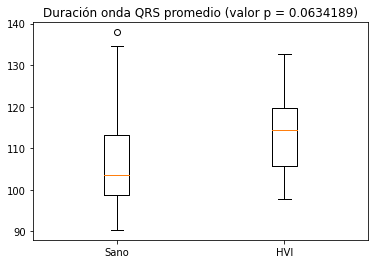

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


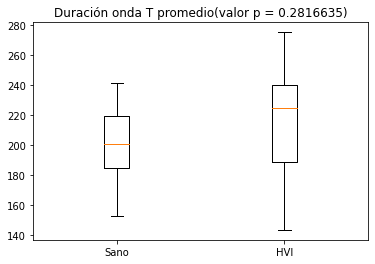

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


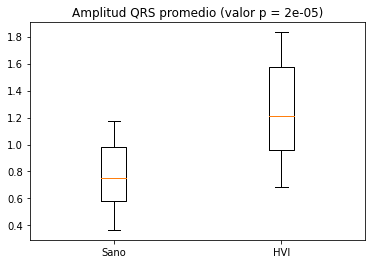

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


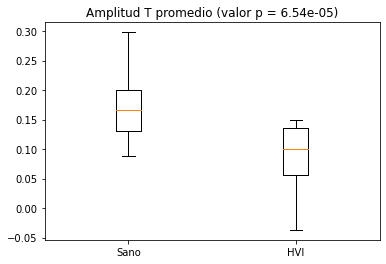

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


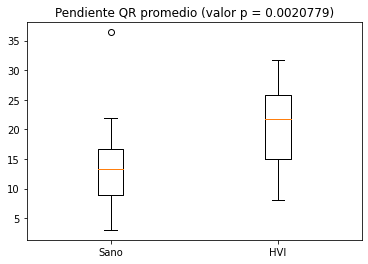

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


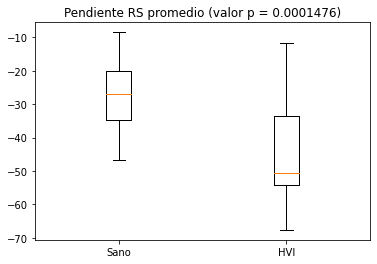

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


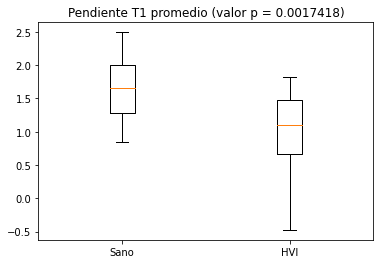

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


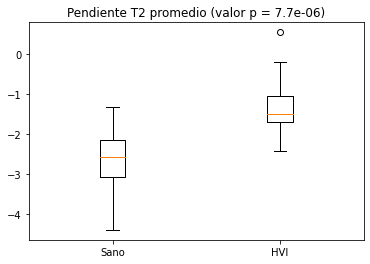

In [ ]:
#__________________________________________
#T-TEST

#Duración QRS:
p_DuracionQRS=stats.ttest_ind(Duracion_QRS_avg_Sano, Duracion_QRS_avg_HVI)[1]

#Amplitud QRS:
p_AmplitudQRS=stats.ttest_ind(Amplitud_QRS_avg_Sano, Amplitud_QRS_avg_HVI)[1]

#Pendiente QR:
p_PendienteQR=stats.ttest_ind(PendienteQR_avg_Sano, PendienteQR_avg_HVI)[1]

#Pendiente RS:
p_PendienteRS=stats.ttest_ind(PendienteRS_avg_Sano, PendienteRS_avg_HVI)[1]

#Duración T:
p_DuracionT=stats.ttest_ind(Duracion_T_avg_Sano, Duracion_T_avg_HVI)[1]

#Amplitud T:
p_AmplitudT=stats.ttest_ind(Amplitud_T_avg_Sano, Amplitud_T_avg_HVI)[1]

#Pendiente T1:
p_PendienteT1=stats.ttest_ind(PendienteT1_avg_Sano, PendienteT1_avg_HVI)[1]

#Pendiente T2:
p_PendienteT2=stats.ttest_ind(PendienteT2_avg_Sano, PendienteT2_avg_HVI)[1]


#________________________________________________________________

#Graficamos boxplots de a pares segun si el algoritmo lo clasifica como sano o HVI
#Duración QRS
ticks = range(1,3)
labels = ['Sano','HVI']
plt.figure()
plt.title('Duración onda QRS promedio (valor p = {})'.format(np.around(p_DuracionQRS,7)))
plt.boxplot(np.transpose([Duracion_QRS_avg_Sano,Duracion_QRS_avg_HVI]))
plt.xticks(ticks,labels)
plt.show()

#Duración T
plt.figure()
plt.title('Duración onda T promedio(valor p = {})'.format(np.around(p_DuracionT,7)))
plt.boxplot(np.transpose([Duracion_T_avg_Sano,Duracion_T_avg_HVI]))
plt.xticks(ticks,labels)
plt.show()

#Amplitud QRS
plt.figure()
plt.title('Amplitud QRS promedio (valor p = {})'.format(np.around(p_AmplitudQRS,7)))
plt.boxplot(np.transpose([Amplitud_QRS_avg_Sano,Amplitud_QRS_avg_HVI]))
plt.xticks(ticks,labels)
plt.show()

#Amplitud T
plt.figure()
plt.title('Amplitud T promedio (valor p = {})'.format(np.around(p_AmplitudT,7)))
plt.boxplot(np.transpose([Amplitud_T_avg_Sano,Amplitud_T_avg_HVI]))
plt.xticks(ticks,labels)
plt.show()

#Pendiente QR
plt.figure()
plt.title('Pendiente QR promedio (valor p = {})'.format(np.around(p_PendienteQR,7)))
plt.boxplot(np.transpose([PendienteQR_avg_Sano,PendienteQR_avg_HVI]))
plt.xticks(ticks,labels)
plt.show()

#Pendiente RS
plt.figure()
plt.title('Pendiente RS promedio (valor p = {})'.format(np.around(p_PendienteRS,7)))
plt.boxplot(np.transpose([PendienteRS_avg_Sano,PendienteRS_avg_HVI]))
plt.xticks(ticks,labels)
plt.show()

#Pendiente T1
plt.figure()
plt.title('Pendiente T1 promedio (valor p = {})'.format(np.around(p_PendienteT1,7)))
plt.boxplot(np.transpose([PendienteT1_avg_Sano,PendienteT1_avg_HVI]))
plt.xticks(ticks,labels)
plt.show()

#Pendiente T2
plt.figure()
plt.title('Pendiente T2 promedio (valor p = {})'.format(np.around(p_PendienteT2,7)))
plt.boxplot(np.transpose([PendienteT2_avg_Sano,PendienteT2_avg_HVI]))
plt.xticks(ticks,labels)
plt.show()

Para los test t, se tomó que un valor p menor a 0.05 correspondía a una diferencia significativa. Por lo tanto, las características que presentaron los menores valores p entre un paciente sano y uno con HVI resultan ser:


*   Amplitud del QRS
*   Amplitud de la onda T
*   Pendiente de RS
*   Pendiente de bajada de la onda T



In [ ]:
datos_mejorados=[datos[:,1],datos[:,3],datos[:,5],datos[:,7]]
datos_mejorados=np.transpose(datos_mejorados)

print("0 --> Paciente sano\n1--> HVI ")

X1=scale(datos_mejorados)
kmeans_mejorado = KMeans(n_clusters=2).fit(X1)

Grupo_sano_real=0
Grupo_HVI_real=0
Grupo_sano_predicho=0
Grupo_HVI_predicho=0
Aciertos=0
Errados=0
for elemento in range(len(kmeans_mejorado.labels_)):
    if kmeans_mejorado.labels_[elemento]==targets[elemento]:
        Aciertos+=1
    else:
        Errados+=1
    if kmeans_mejorado.labels_[elemento]==1:
        Grupo_HVI_predicho+=1
    else:
        Grupo_sano_predicho+=1
    if targets[elemento]==1:
        Grupo_sano_real+=1
    else:
        Grupo_HVI_real+=1

tasa_aciertos= (Aciertos/(Aciertos + Errados))*100

print("----------------- KMEANS ------------------\n")

print("Las marcas reales son: ", targets)
print("Las marcas del kmeans son: ",kmeans_mejorado.labels_)

print("Hay", Grupo_HVI_real, "pacientes con HVI y ",Grupo_sano_real, " pacientes sanos segun las marcas del médico")
print("Hay", Grupo_HVI_predicho, "pacientes con HVI y ",Grupo_sano_predicho, " pacientes sanos segun el algoritmo de clustering")
print("Hay ", Aciertos ," Aciertos y ", Errados , "datos clasificados de forma errónea")
print('Entonces, el porcentaje de aciertos es del:',tasa_aciertos,"%")


0 --> Paciente sano
1--> HVI 
----------------- KMEANS ------------------

Las marcas reales son:  [0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 1 1 0 1 1 1 1 0 0 1 0 1 0 1 1 1 1 0 1 0
 1 1 1]
Las marcas del kmeans son:  [1 0 0 0 1 0 0 0 0 0 1 1 1 0 1 0 0 1 1 1 0 0 0 0 0 0 1 0 0 0 1 1 1 0 0 1 0
 0 0 0]
Hay 21 pacientes con HVI y  19  pacientes sanos segun las marcas del médico
Hay 14 pacientes con HVI y  26  pacientes sanos segun el algoritmo de clustering
Hay  23  Aciertos y  17 datos clasificados de forma errónea
Entonces, el porcentaje de aciertos es del: 57.49999999999999 %


#Aprendizaje Supervisado

Teniendo el cuenta los diagnósticos reales, se eleboró un clasificador mediante SVM y otro con KNN para determinar el diagnóstico en pacientes de un set de datos de testeo. Se separaron los datos en dos grupos. Un grupo de datos son los datos de entrenamiento, que corresponden al 70% mientras que el resto son los datos de testeo. Para cada Algoritmo se calculó la matriz de confusión 

##SVM

Matriz de confusión
[[6 1]
 [1 4]]


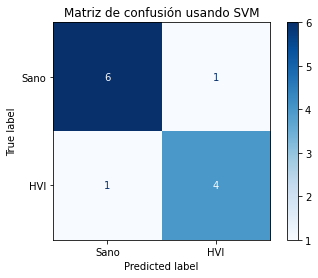

------------- RESULTADOS DEL MODELO SUPERVISADO (SVM) -------------------
La precisión del modelo fue de: 80.0 %
La sensibilidad del modelo fue de:  80.0 %
La exactitud del modelo fue de: 83.33333333333334 %
La especifidad del modelo fue de: 85.71428571428571 %


In [ ]:
#Aprendizaje supervisado usando SVM


clf = svm.SVC()

n_sample = len(X1)
order = np.random.permutation(n_sample)
X_svm = datos_mejorados[order,:] #input
y_svm= targets[order] #output


X_svm_train, X_svm_test, y_svm_train, y_svm_test = train_test_split(X_svm,y_svm, test_size = 0.3)


clf.fit(X_svm_train, y_svm_train)

#Matriz de confusión 

disp = plot_confusion_matrix(clf,X_svm_test, y_svm_test, display_labels = ["Sano", "HVI"], cmap = plt.cm.Blues)
disp.ax_.set_title('Matriz de confusión usando SVM')

print('Matriz de confusión')
print(disp.confusion_matrix)
plt.show()

#CALCULO DE DISTINTOS PARÁMETROS:


f_neg=disp.confusion_matrix[1,0]
v_neg=disp.confusion_matrix[0,0]
f_pos=disp.confusion_matrix[0,1]
v_pos=disp.confusion_matrix[1,1]




precision=(v_pos/(v_pos+f_pos))*100
sensibilidad=v_pos/(v_pos+f_neg) *100
especifidad=v_neg/(v_neg+f_pos) * 100
exactitud=(v_neg+v_pos)/(v_neg+v_pos+f_pos+f_neg) *100

print("------------- RESULTADOS DEL MODELO SUPERVISADO (SVM) -------------------")

print("La precisión del modelo fue de:",precision,"%")

print("La sensibilidad del modelo fue de: ", sensibilidad, "%")

print("La exactitud del modelo fue de:",exactitud,"%")

print("La especifidad del modelo fue de:",especifidad,"%")

##K Nearest Neighbors

Matriz de confusión
[[7 0]
 [2 3]]


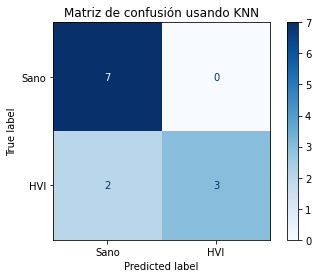

------------- RESULTADOS DEL MODELO SUPERVISADO (KNN) -------------------
La precisión del modelo fue de: 100.0 %
La sensibilidad del modelo fue de:  60.0 %
La exactitud del modelo fue de: 83.33333333333334 %
La especifidad del modelo fue de: 100.0 %


In [ ]:
clf = KNeighborsClassifier(n_neighbors=2)

n_sample = len(X1)
order = np.random.permutation(n_sample)
X_knn = datos_mejorados[order,:] #input
y_knn= targets[order] #output


X_knn_train, X_knn_test, y_knn_train, y_knn_test = train_test_split(X_knn,y_knn, test_size = 0.3)


clf.fit(X_knn_train, y_knn_train)



#Matriz de confusión 

disp = plot_confusion_matrix(clf,X_svm_test, y_svm_test, display_labels = ["Sano", "HVI"], cmap = plt.cm.Blues)
disp.ax_.set_title('Matriz de confusión usando KNN')

print('Matriz de confusión')
print(disp.confusion_matrix)
plt.show()


#CALCULO DE DISTINTOS PARÁMETROS:


f_neg=disp.confusion_matrix[1,0]
v_neg=disp.confusion_matrix[0,0]
f_pos=disp.confusion_matrix[0,1]
v_pos=disp.confusion_matrix[1,1]




precision=(v_pos/(v_pos+f_pos))*100
sensibilidad=v_pos/(v_pos+f_neg) *100
especifidad=v_neg/(v_neg+f_pos) * 100
exactitud=(v_neg+v_pos)/(v_neg+v_pos+f_pos+f_neg) *100

print("------------- RESULTADOS DEL MODELO SUPERVISADO (KNN) -------------------")

print("La precisión del modelo fue de:",precision,"%")

print("La sensibilidad del modelo fue de: ", sensibilidad, "%")

print("La exactitud del modelo fue de:",exactitud,"%")

print("La especifidad del modelo fue de:",especifidad,"%")